<h1> Music Artisits Analysis </h1>

This notebook is about interpreting in what way or sense two or more music artists are similar.

This is done using unsupervised learning by the method of clustering. There are many different algorithms like K-Means, K-Median, DBSCAN but I am using AHC(Agglomerative Hierarchical Clustering).

I built **Agglomerative Hierarchical Clustering algorithm from scratch** with four common types of distance measures (linkages) named single linkage, Complete linkage, average linkage, centroid linkage.

Here I am  using spotify data which contains more than 160k songs from the year 1921 to 2021. The factors to be analysed are:
<h3> Primary: </h3>
id (Id of track generated by Spotify)
<h3> Numerical: </h3>
acousticness (Ranges from 0 to 1)
danceability (Ranges from 0 to 1)
energy (Ranges from 0 to 1)
duration_ms (Integer typically ranging from 200k to 300k)
instrumentalness (Ranges from 0 to 1)
valence (Ranges from 0 to 1)
popularity (Ranges from 0 to 100)
tempo (Float typically ranging from 50 to 150)
liveness (Ranges from 0 to 1)
loudness (Float typically ranging from -60 to 0)
speechiness (Ranges from 0 to 1)
year (Ranges from 1921 to 2020)
<h3> Dummy: </h3>
mode (0 = Minor, 1 = Major)
explicit (0 = No explicit content, 1 = Explicit content)
<h3> Categorical: </h3>
key (All keys on octave encoded as values ranging from 0 to 11, starting on C as 0, C# as 1 and so on…)
artists (List of artists mentioned)
release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
name (Name of the song)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as distance
from math import sqrt
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from collections import namedtuple



In [2]:
linkageFunctions=['single','complete','average','centroid'];

class LinkageLabel:
    def __init__(self,n):
        self.parent=np.arange((2*n)-1)
        self.nextLabel=n
        self.size=np.ones((2*n)-1)

    def join(self,left,right):
        self.parent[left]=self.nextLabel
        self.parent[right]=self.nextLabel
        size=self.size[left]+self.size[right]
        self.size[self.nextLabel]=size
        self.nextLabel+=1
        return size

    def getElement(self,left):
        temp=left
        while self.parent[left]!=left:
            left=self.parent[left]
        while self.parent[temp]!=left:
            temp, self.parent[temp]=self.parent[temp],left
        return left
    
class Node:
    def __init__(self, name, height = 0, observations = 1, leftNode = None, rightNode = None):
        self.name = name
        self.leftNode = leftNode
        self.rightNode = rightNode
        self.height = height
        if self.leftNode is None:
            self.height = height
        else:
            self.height = left.height + right.height

    def is_leaf(self):
        return self.left==None


<h4> While loading the data I removed some of the factors which are not numerical and not necessary for this interpretation </h4>

In [3]:
def loadData():
    dataNodes=[]
    dataset=pd.read_csv("spotifydata.csv")
    dataset= pd.DataFrame(dataset)
    dataset=dataset.drop(labels=['artists','explicit','key','mode','name','release_date','id'], axis=1)
    dataset=dataset.head(50)
    #dataset=dataset.round(2)
    #dataset=dataset.to_numpy()
    return dataset


In [4]:
def distanceIndex(obs,rowVal,colVal):
    if rowVal<colVal:
        return int(obs*rowVal-(rowVal*(rowVal+1)/2)+(colVal-rowVal-1))
    elif rowVal>colVal:
        return int(obs*colVal-(colVal*(colVal+1)/2)+(rowVal-colVal-1))

def findLabel(mat,obs):
    vals=LinkageLabel(obs)
    for i in range(obs-1):
        x,y=int(mat[i,0]),int(mat[i,1])
        xRootElement,yRootElement=vals.getElement(x),vals.getElement(y)
        if xRootElement<yRootElement:
            mat[i, 0], mat[i, 1] = xRootElement, yRootElement
        else:
            mat[i, 0], mat[i, 1] = yRootElement, xRootElement
        mat[i, 3]=vals.join(xRootElement, yRootElement)
    return


In [5]:
def performLinkage(dataPoints,obs, method):
    resArr=np.empty((obs-1,4))
    result=resArr
    distanceMat=dataPoints.copy()
    size=np.ones(obs,dtype=int)
    clusterArr=np.ndarray(obs, dtype=int)
    clusterLen=0
    x=0
    y=0
    distance=0
    curMin=0

    for k in range(obs-1):
        if clusterLen==0:
            clusterLen=1
            for i in range(obs):
                if size[i]>0:
                    clusterArr[0]=i
                    break
        while True:
            x=clusterArr[clusterLen-1]
            if clusterLen>1:
                y=clusterArr[clusterLen-2]
                curMin=distanceMat[distanceIndex(obs,x,y)]
            else:
                curMin=np.inf
            for i in range(obs):
                if size[i]==0 or x==i:
                    continue
                distance=distanceMat[distanceIndex(obs,x,i)]
                if distance<curMin:
                    curMin=distance
                    y=i
            if clusterLen>1 and y==clusterArr[clusterLen-2]:
                break

            clusterArr[clusterLen]=y
            clusterLen+=1

        clusterLen-=2
        if x>y:
            x,y=y,x
        nx=size[x]
        ny=size[y]
        result[k, 0] = x
        result[k, 1] = y
        result[k, 2] = curMin
        result[k, 3] = nx + ny
        size[x] = 0  
        size[y] = nx + ny  
        
        for i in range(obs):
            ni=size[i]
            if ni==0 or i==y:
                continue
            if method==0:
                distanceMat[distanceIndex(obs,i,y)]=min(
                        distanceMat[distanceIndex(obs,i,x)],
                        distanceMat[distanceIndex(obs,i,y)],)
                
            elif method==1:
                distanceMat[distanceIndex(obs,i,y)] = max(
                        distanceMat[distanceIndex(obs,i,x)],
                        distanceMat[distanceIndex(obs,i,y)],)
            elif method==2:
                distanceMat[distanceIndex(obs,i,y)] = average(
                        distanceMat[distanceIndex(obs,i,x)],
                        distanceMat[distanceIndex(obs,i,y)],
                        nx,ny)
            else :
                distanceMat[distanceIndex(obs,i,y)] = centroid(
                        distanceMat[distanceIndex(obs,i,x)],
                        distanceMat[distanceIndex(obs,i,y)],
                        curMin,nx,ny,ni)
                
    order=np.argsort(resArr[:,2])
    resArr=resArr[order]

    findLabel(resArr, obs)

    return resArr


In [6]:
def average(disx,disy,xsize,ysize):
    return (xsize*disx+ysize*disy)/(xsize+ysize)

def centroid(disx,disy,disxy,xsize, ysize, isize):
    xvals=xsize*disx*disx
    yvals=ysize*disy*disy
    cx=xsize*ysize*disxy*disxy
    sizexy=xsize+ysize
    return sqrt(((xvals+yvals)-cx/sizexy) / sizexy)

def initiateClustering(y, method):
    y=distance.pdist(y)
    n=int(distance.num_obs_y(y))
    method_code=linkageFunctions.index(method)
    result=performLinkage(y, n, method_code)
    return result

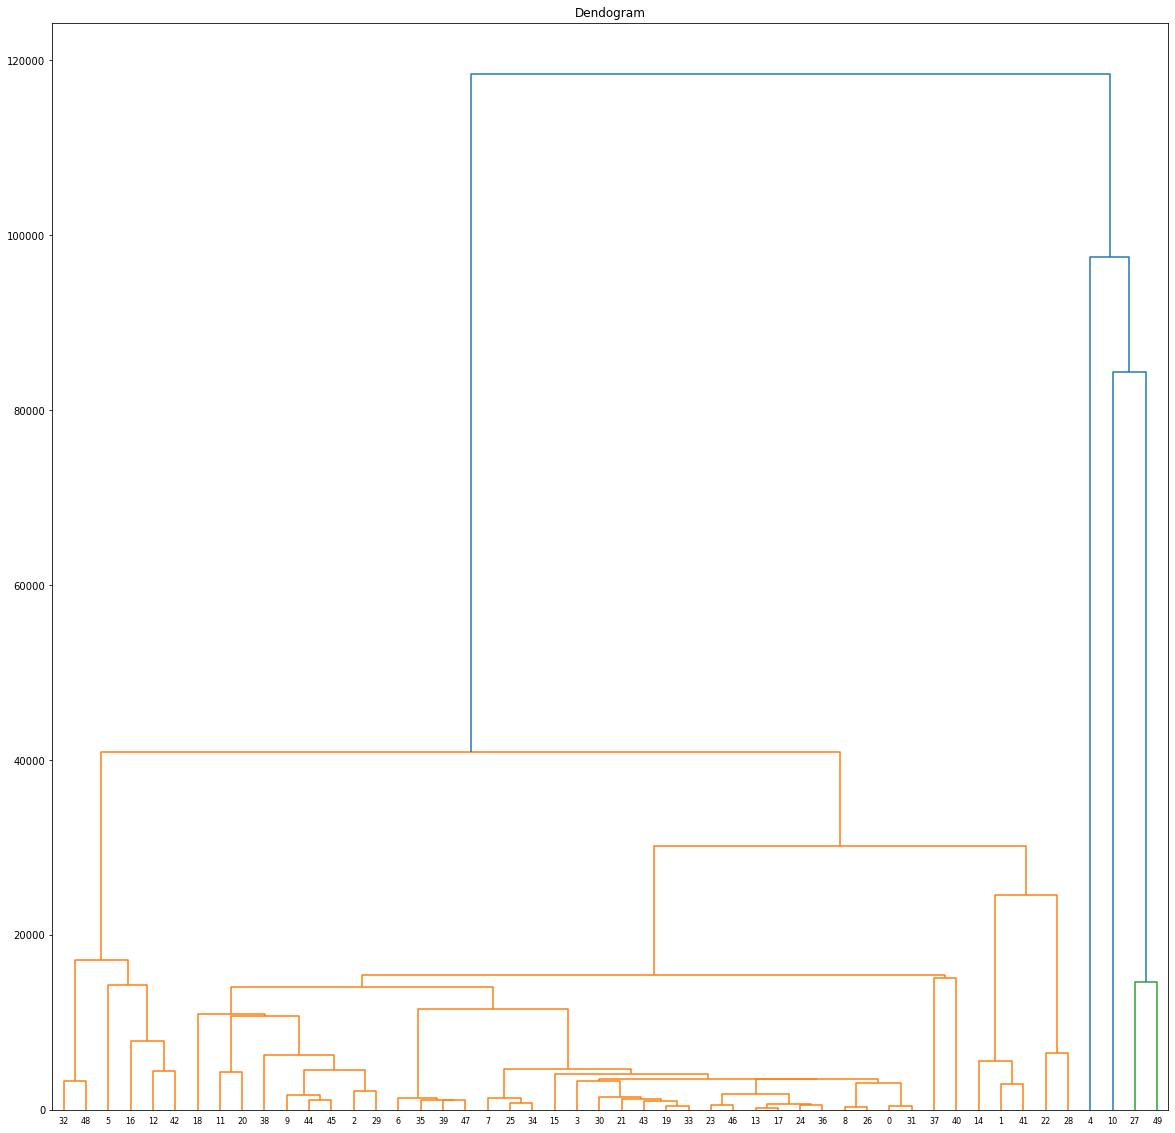

In [7]:
data=loadData();  
clusteredData = initiateClustering(data, method='single')
plt.figure(figsize=(20,20))
plt.title("Dendogram")
#print(clusteredData);
singleDendrogram = dendrogram(clusteredData,leaf_rotation=0,leaf_font_size=8,)

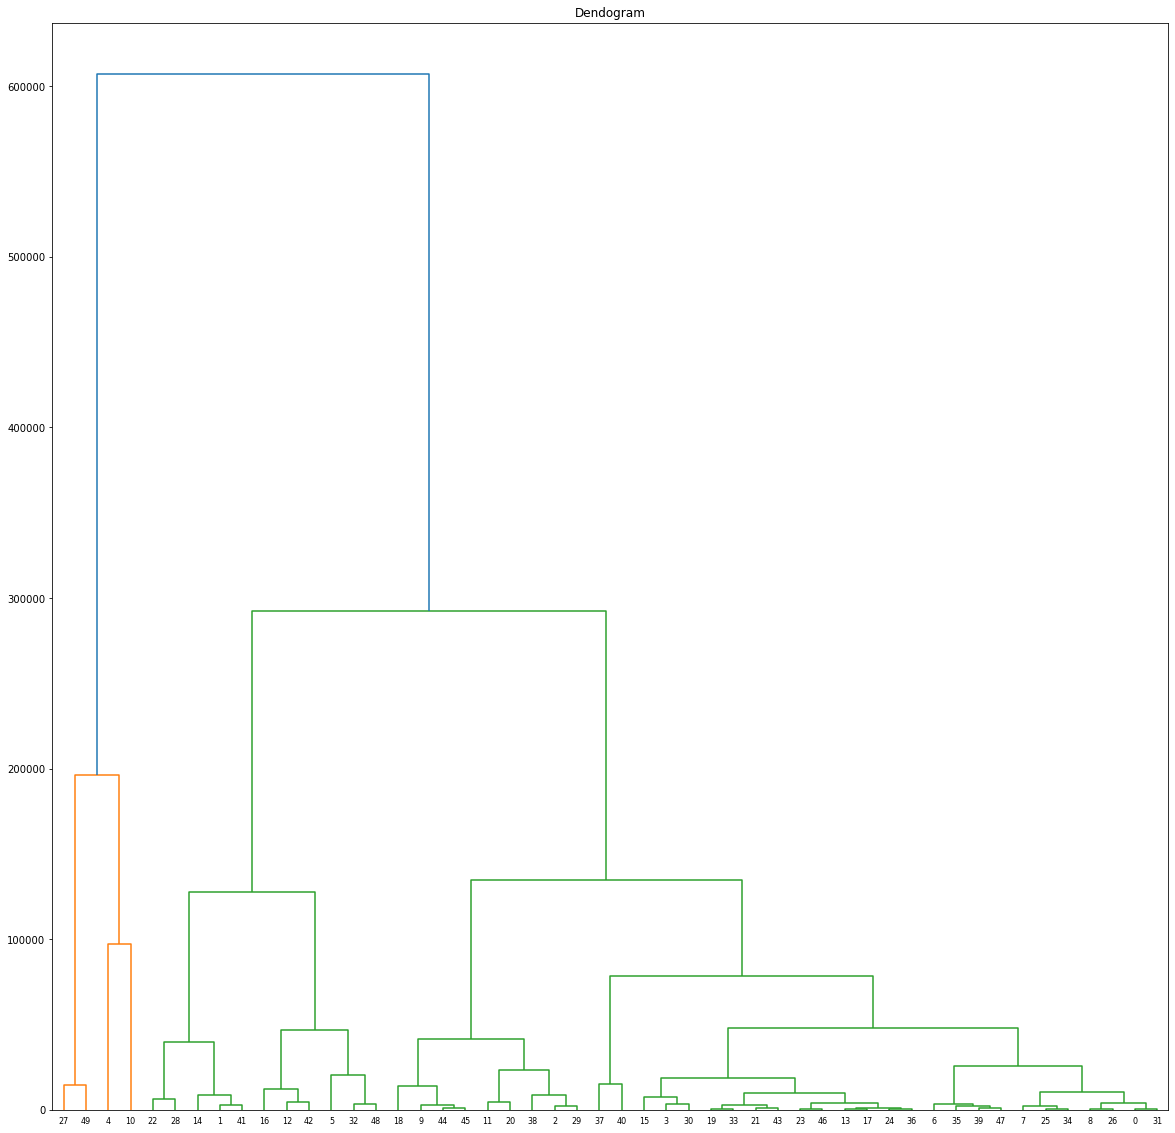

In [8]:
completeClusteredData = initiateClustering(data, method='complete')
plt.figure(figsize=(20,20))
plt.title("Dendogram")

completeDendrogram = dendrogram(completeClusteredData,leaf_rotation=0,leaf_font_size=8,)

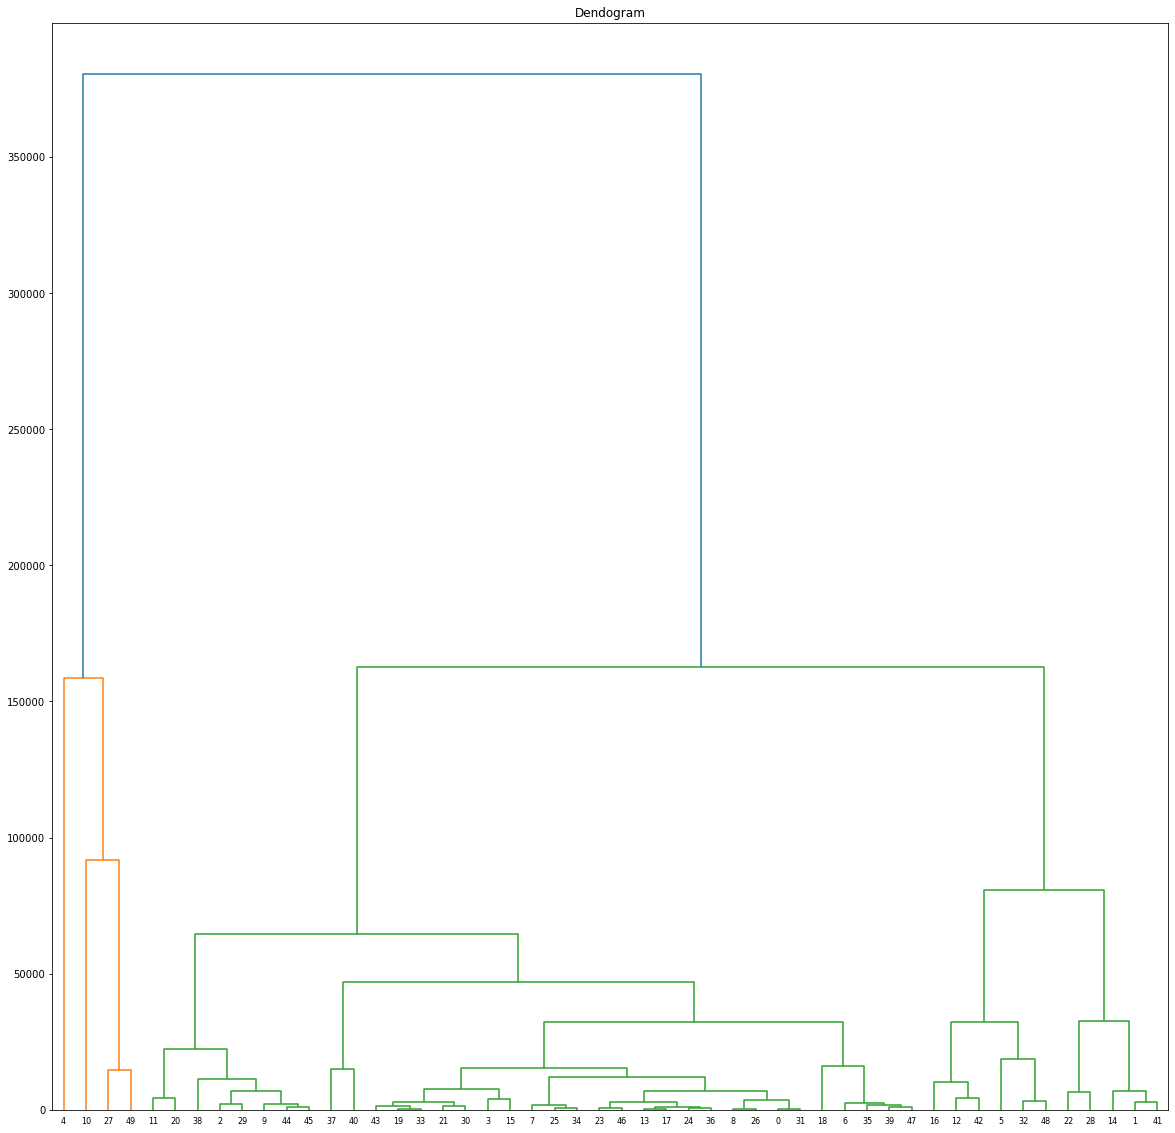

In [9]:
averageClusteredData = initiateClustering(data, method='average')
plt.figure(figsize=(20,20))
plt.title("Dendogram")

averageDendrogram = dendrogram(averageClusteredData,leaf_rotation=0,leaf_font_size=8,)

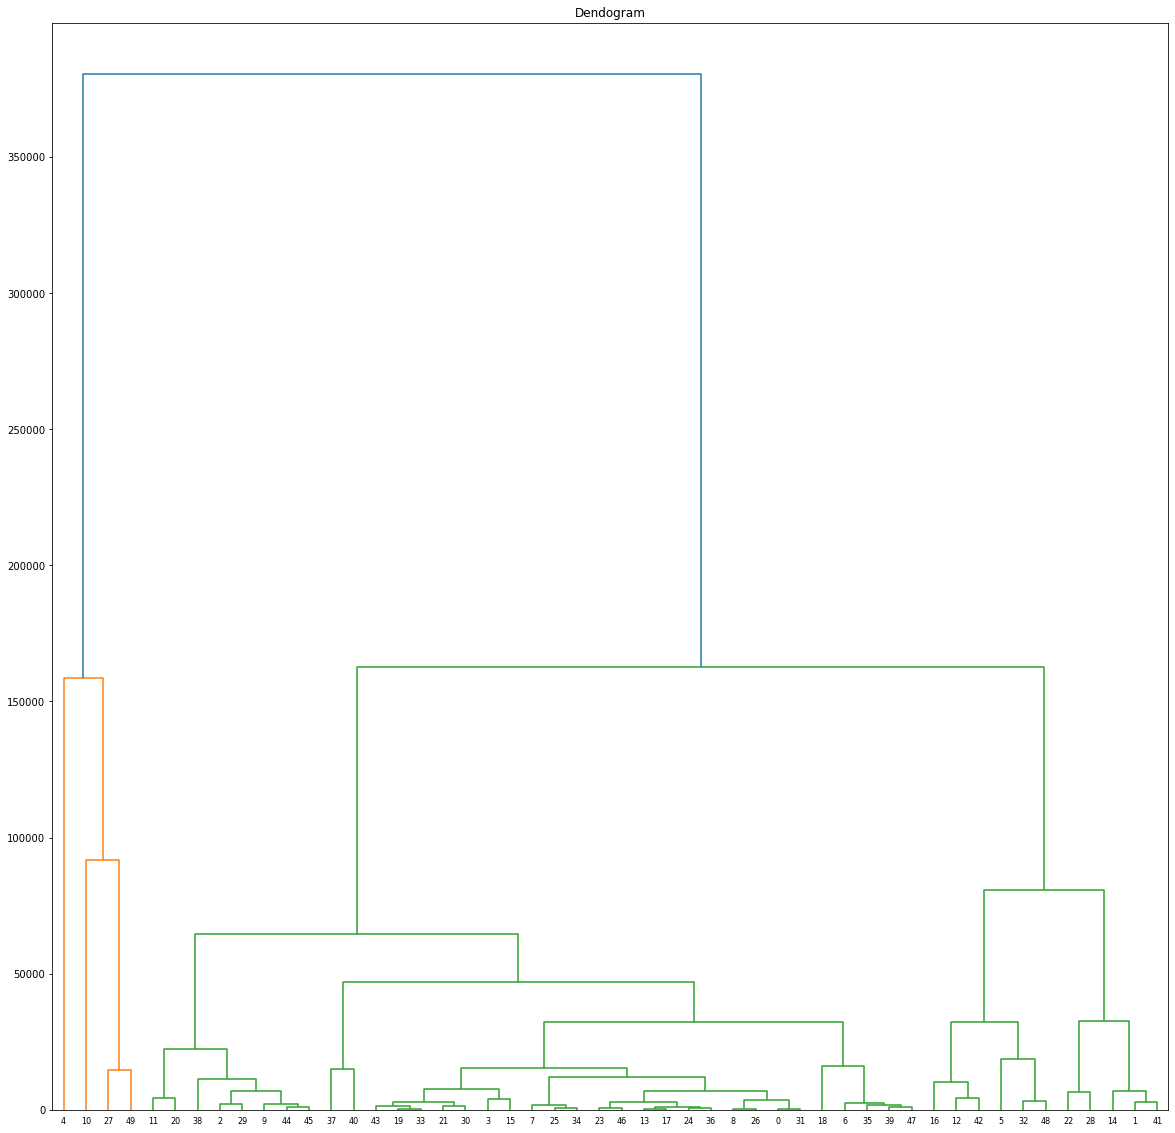

In [10]:
centroidClusteredData = initiateClustering(data, method='centroid')
plt.figure(figsize=(20,20))
plt.title("Dendogram")

centroidDendrogram = dendrogram(centroidClusteredData,leaf_rotation=0,leaf_font_size=8,)

In [11]:
def getClusters(clusteredData,k):
    i= len(clusteredData)-k-k;
    headNodes=[]
    while i<len(clusteredData-k):
        headNodes.append(clusteredData[i]);
        i+=1;
    print("The head nodes of",k,"nodes are",headNodes);
    return headNodes

getClusters(clusteredData,4);

The head nodes of 4 nodes are [array([   87.        ,    90.        , 15373.03724073,    35.        ]), array([7.10000000e+01, 8.80000000e+01, 1.71211066e+04, 6.00000000e+00]), array([8.0000000e+01, 8.2000000e+01, 2.4603002e+04, 5.0000000e+00]), array([   91.        ,    93.        , 30173.01035537,    40.        ]), array([   92.       ,    94.       , 40934.0009236,    46.       ]), array([1.00000000e+01, 8.90000000e+01, 8.43730005e+04, 3.00000000e+00]), array([4.00000000e+00, 9.60000000e+01, 9.74400324e+04, 4.00000000e+00]), array([9.50000000e+01, 9.70000000e+01, 1.18371009e+05, 5.00000000e+01])]


<h1> Conclusion </h1>
The benefit of using Agglomerative Hierarchical Clustering algorithm is we don't have to define number of clusters beforehand. We can cut the dendrogram at an appropriate height to have the better results. 

Also we can conclude our result by looking at any type of linkage. I am concluding by only single linkage. 

1. With single linkage the first cluster formed is between 13 and 17 music artist named ['Samuel Barber', 'Vladimir Horowitz'] and ['Alexander Scriabin', 'Vladimir Horowitz']. we can easily visualize the metrics to verify which factors are contributing most towards the similairty between these two artist.

In [12]:
result=loadData()
result.loc[[12]]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
12,0.99,0.359,338333,0.0435,0.899,0.109,-20.858,0,0.0424,96.645,0.042,1928


In [13]:
result.loc[[16]]

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
16,0.996,0.319,326067,0.155,0.917,0.126,-18.728,0,0.036,66.947,0.0488,1928


we can see except for their energy and tempo many things matches between these two artists.